In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # train set
        df = pd.read_csv('/kaggle/input/aps-failure-at-scania-trucks-data-set/aps_failure_training_set.csv', encoding = "ISO-8859-1")

        # test set
        df_test = pd.read_csv('/kaggle/input/aps-failure-at-scania-trucks-data-set/aps_failure_test_set.csv', encoding = "ISO-8859-1")

# EDA

In [2]:
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


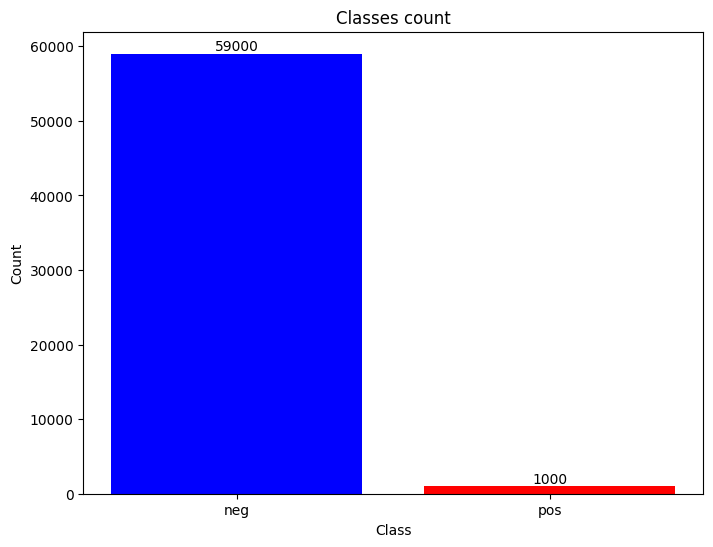

In [3]:
# Classes counts
counts = df['class'].value_counts()

# Creating a bar graph
plt.figure(figsize=(8, 6))
bars = plt.bar(counts.index, counts.values, color=['blue', 'red'])

# Adding the number on the bars
for bar, count in zip(bars, counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, count,
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Classes count')
plt.show()

Based on this, we can observe that there are many more data points classified as 'neg', which correspond to air systems without defects, than data points classified as 'pos', which are anomalous air systems.

In [4]:
# Count of missing values ('na') per column
missing_counts = df.apply(lambda x: x[x == 'na'].count())
total_counts = len(df)
missing_percentages = (missing_counts / total_counts) * 100

# Create DataFrame with the results
missing_df = pd.DataFrame({'Column': missing_counts.index,
                           'Missing Values': missing_counts.values,
                           'Percentage of Missing Values': missing_percentages.values})

# Filter and sort by percentage of missing values
missing_df = missing_df[missing_df['Missing Values'] > 0]
missing_df = missing_df.sort_values(by='Percentage of Missing Values', ascending=False)

print(missing_df)

    Column  Missing Values  Percentage of Missing Values
79  br_000           49264                     82.106667
78  bq_000           48722                     81.203333
77  bp_000           47740                     79.566667
76  bo_000           46333                     77.221667
2   ab_000           46329                     77.215000
..     ...             ...                           ...
85  by_000             473                      0.788333
95  ci_000             338                      0.563333
96  cj_000             338                      0.563333
97  ck_000             338                      0.563333
81  bt_000             167                      0.278333

[169 rows x 3 columns]


In [5]:
# Get columns with more than 50% missing values
columns_with_missing_values = missing_df[missing_df['Percentage of Missing Values'] > 50]['Column'].tolist()
columns_with_missing_values.append('cd_000') # constant column
print(columns_with_missing_values)

['br_000', 'bq_000', 'bp_000', 'bo_000', 'ab_000', 'cr_000', 'bn_000', 'bm_000', 'cd_000']


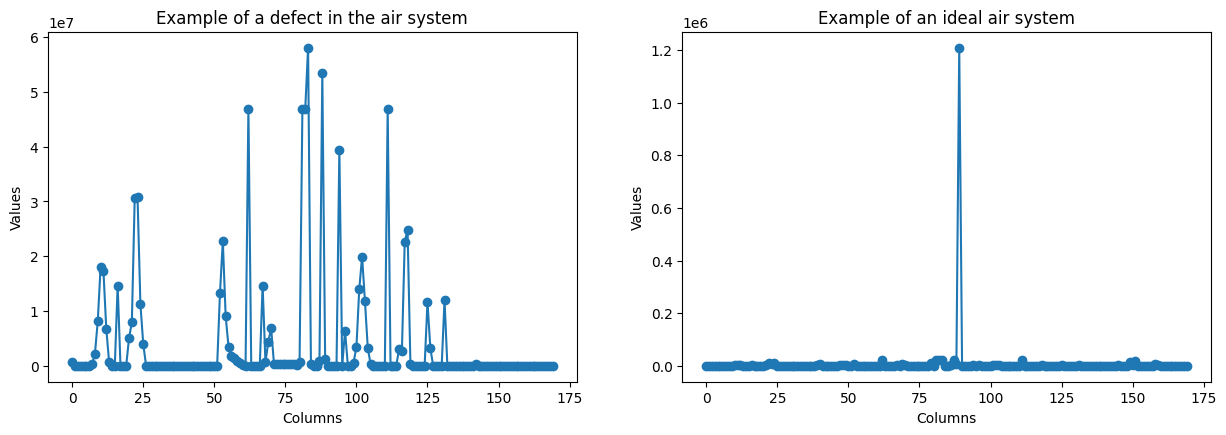

In [6]:
def plot_examples(index: int) -> None:
    df_copy = df.copy()

    # Replace 'na' with 0 just for visualization
    df_copy.replace('na', 0, inplace=True)

    example_pos = df_copy[df_copy['class'] == 'pos'].iloc[index].drop('class', axis=0)
    example_neg = df_copy[df_copy['class'] == 'neg'].iloc[index].drop('class', axis=0)

    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.plot(example_pos.values, marker='o', linestyle='-')
    plt.xlabel('Columns')  # Adjust according to column names
    plt.ylabel('Values')
    plt.title('Example of a defect in the air system')

    plt.subplot(2, 2, 2)
    plt.plot(example_neg.values, marker='o', linestyle='-')
    plt.xlabel('Columns')  # Adjust according to column names
    plt.ylabel('Values')
    plt.title('Example of an ideal air system')
    plt.show()

plot_examples(3)


This way, we can visualize an example of an ideal air system and an anomalous air system to start understanding the dataset we are working with. One idea that arises from this is to analyze the quartiles of an anomalous data point and an ideal data point to try to identify any interesting differences that could be useful for training a future machine learning model.



In [7]:
df.dtypes

class     object
aa_000     int64
ab_000    object
ac_000    object
ad_000    object
           ...  
ee_007    object
ee_008    object
ee_009    object
ef_000    object
eg_000    object
Length: 171, dtype: object

We need to cast the object columns to numeric because we know they are numerical. This will significantly improve the performance of operations performed on the DataFrame and also allow us to perform calculations on these numbers, avoiding potential conflicts.

In [8]:
# We want all columns except the first one, 'class', to be converted.
cols_to_convert = df.columns[1:]
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')
df.dtypes


class      object
aa_000      int64
ab_000    float64
ac_000    float64
ad_000    float64
           ...   
ee_007    float64
ee_008    float64
ee_009    float64
ef_000    float64
eg_000    float64
Length: 171, dtype: object

In [9]:
def describe_examples(df) -> None:
    df_pos = df[df['class'] == 'pos'].drop('class', axis=1).mean()
    df_neg = df[df['class'] == 'neg'].drop('class', axis=1)
    print('POS:')
    print(df_pos.describe(include='all'))
    print('NEG:')
    print(df_neg.describe(include='all'))

describe_examples(df)


POS:
count    1.700000e+02
mean     6.635108e+06
std      1.622531e+07
min      5.633803e-03
25%      1.598809e+04
50%      4.619795e+05
75%      4.526754e+06
max      1.179959e+08
dtype: float64
NEG:
             aa_000        ab_000        ac_000        ad_000        ae_000  \
count  5.900000e+04  13442.000000  5.612700e+04  4.478400e+04  56841.000000   
mean   4.916977e+04      0.698706  3.588573e+08  1.921137e+05      6.664802   
std    1.100525e+05      3.458102  7.974031e+08  4.056424e+07    160.498622   
min    0.000000e+00      0.000000  0.000000e+00  0.000000e+00      0.000000   
25%    7.840000e+02      0.000000  1.600000e+01  2.400000e+01      0.000000   
50%    3.041600e+04      0.000000  1.500000e+02  1.240000e+02      0.000000   
75%    4.549300e+04      0.000000  9.420000e+02  4.260000e+02      0.000000   
max    2.434708e+06    204.000000  2.130707e+09  8.584298e+09  21050.000000   

             af_000        ag_000         ag_001        ag_002        ag_003  \
count  

The mean being similar to the median indicates symmetry in the distribution of values in our datasets. At first glance, I expected there would be a significant difference between these two statistical measures due to the differing proportions of some observed values.

In [10]:
# Define outlier criteria
outlier_limits = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]

# Function to count outliers and calculate percentages for the specified class
def count_outliers_by_class(df, class_name):
    # Filter DataFrame by the specified class
    df_class = df[df['class'] == class_name]

    # Initialize outlier counters and total data
    total_outliers = [0] * len(outlier_limits)
    total_data = 0

    # Iterate over each numeric column and count outliers
    for col in df_class.select_dtypes(include='number').columns:
        total_data += df_class[col].count()
        for i, limit in enumerate(outlier_limits):
            outliers = df_class[col][df_class[col] > limit]
            total_outliers[i] += outliers.count()

    # Calculate percentages
    percent_outliers = [(total_outliers[i] / total_data) * 100 for i in range(len(outlier_limits))]

    return percent_outliers, total_data

# Calculate outlier percentages for 'pos' and 'neg'
percent_outliers_pos, total_pos = count_outliers_by_class(df, 'pos')
percent_outliers_neg, total_neg = count_outliers_by_class(df, 'neg')

# Print results
for i, limit in enumerate(outlier_limits):
    print(f"Percentage of outliers > {limit:.0e} for 'pos': {percent_outliers_pos[i]:.2f}% (Total 'pos' = {total_pos})")
    print(f"Percentage of outliers > {limit:.0e} for 'neg': {percent_outliers_neg[i]:.2f}% (Total 'neg' = {total_neg})")


Percentage of outliers > 1e+01 for 'pos': 74.15% (Total 'pos' = 140847)
Percentage of outliers > 1e+01 for 'neg': 62.49% (Total 'neg' = 9209138)
Percentage of outliers > 1e+02 for 'pos': 72.56% (Total 'pos' = 140847)
Percentage of outliers > 1e+02 for 'neg': 56.15% (Total 'neg' = 9209138)
Percentage of outliers > 1e+03 for 'pos': 69.34% (Total 'pos' = 140847)
Percentage of outliers > 1e+03 for 'neg': 47.11% (Total 'neg' = 9209138)
Percentage of outliers > 1e+04 for 'pos': 63.03% (Total 'pos' = 140847)
Percentage of outliers > 1e+04 for 'neg': 36.10% (Total 'neg' = 9209138)
Percentage of outliers > 1e+05 for 'pos': 53.37% (Total 'pos' = 140847)
Percentage of outliers > 1e+05 for 'neg': 23.95% (Total 'neg' = 9209138)
Percentage of outliers > 1e+06 for 'pos': 34.73% (Total 'pos' = 140847)
Percentage of outliers > 1e+06 for 'neg': 10.03% (Total 'neg' = 9209138)
Percentage of outliers > 1e+07 for 'pos': 14.55% (Total 'pos' = 140847)
Percentage of outliers > 1e+07 for 'neg': 0.86% (Total 'ne

Cool! This is an interesting feature to be used in the model preprocessing. We can observe that as the value range increases and the magnitude of outliers grows, they are more likely to appear in anomalous data and less in ideal data. Based on this, we can use some high percentiles as features in our model. We can see that quartiles are very valuable information for us; in the overwhelming majority of cases, high quartiles are distinct between an anomalous example and an ideal example.

# Data Preprocessing

In [11]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    # Replace 'na' with NaN
    df = df.replace('na', np.nan)

    # Remove columns specified in columns_with_missing_values
    df = df.drop(columns=columns_with_missing_values, errors='ignore')

    df['class'] = pd.Categorical(df['class'])
    # Map 'pos' to 1 and 'neg' to 0
    label_map = {'neg': 0, 'pos': 1}

    # Apply the mapping to the 'class' column
    df['class'] = df['class'].map(label_map)

    # Impute missing values with the median
    numeric_cols = df.select_dtypes(include=np.number).columns
    df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Apply the scaler to the numerical data (excluding the first column)
    df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])

    # Calculate statistics for each row of the DataFrame
    def calculate_row_statistics(row):
        numeric_values = row.iloc[1:].astype(np.float64)  # Selects only numeric columns
        median = np.median(numeric_values)
        mean = np.mean(numeric_values)
        quartiles = np.percentile(numeric_values, [25, 75, 95])
        num_zeros = np.sum(numeric_values == 0)
        num_outliers = np.sum(numeric_values > 1e7)  # Outlier criterion
        return pd.Series([median, mean, quartiles[0], quartiles[1], quartiles[2], num_zeros, num_outliers],
                         index=['Median', 'Mean', '1st Quartile', '3rd Quartile', '95th Percentile',
                                'Number of Zeros', 'Number of Outliers'])

    # Apply the calculate_row_statistics function to each row of the DataFrame
    statistics = df.apply(calculate_row_statistics, axis=1)

    # Concatenate the calculated statistics with the original DataFrame
    df_result = pd.concat([df, statistics], axis=1)

    return df_result

df = preprocess(df)
df.head()


/tmp/ipykernel_18/1073350842.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2.79250729e-02 1.20361295e-02 1.49423061e-02 ... 4.07782233e-05
 2.92336170e-02 1.46444794e-02]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])


,class,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_009,ef_000,eg_000,Median,Mean,1st Quartile,3rd Quartile,95th Percentile,Number of Zeros,Number of Outliers
0,0,0.027925,9.999998e-01,3.261769e-08,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.001868,0.027257,0.0,0.021296,0.057779,52.0,0.0
1,0,0.012036,0.000000e+00,1.467796e-08,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000394,0.000000,0.000000,0.001039,0.014098,0.0,0.008209,0.019709,54.0,0.0
2,0,0.014942,1.070067e-07,1.164918e-08,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000135,0.000000,0.000000,0.000659,0.007745,0.0,0.006622,0.020031,55.0,0.0
3,0,0.000004,3.285295e-08,7.688457e-09,0.0,0.000498,0.0,0.0,0.0,0.000005,...,0.000000,0.008299,0.027923,0.000004,0.002593,0.0,0.000037,0.000652,56.0,0.0
4,0,0.022164,6.420405e-07,5.335323e-08,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000320,0.000000,0.000000,0.001725,0.017165,0.0,0.010527,0.033052,48.0,0.0


In [12]:
# Shuffle the rows of the DataFrame
df = shuffle(df, random_state=42)

# Reset the index after shuffling
df.reset_index(drop=True, inplace=True)

# Check the shuffled DataFrame
df.head()


,class,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_009,ef_000,eg_000,Median,Mean,1st Quartile,3rd Quartile,95th Percentile,Number of Zeros,Number of Outliers
0,0,0.013967,0.000000e+00,1.467796e-08,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002664,0.0,0.0,2.830724e-04,0.021092,0.0,0.011278,0.030039,62.0,0.0
1,0,0.000003,2.815967e-09,6.989506e-10,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,3.336159e-07,0.002485,0.0,0.000026,0.000341,72.0,0.0
2,0,0.016013,9.949750e-08,2.050255e-08,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007617,0.0,0.0,5.097535e-04,0.017994,0.0,0.010655,0.025019,56.0,0.0
3,0,0.017184,1.614488e-07,3.611245e-08,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000300,0.0,0.0,1.045385e-03,0.019766,0.0,0.008122,0.027648,50.0,0.0
4,0,0.014500,3.341614e-07,6.919611e-08,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004445,0.0,0.0,5.058181e-04,0.017544,0.0,0.005696,0.021318,55.0,0.0


# Model Training

In [13]:
# Constructing weights based on the cost matrix
weight = len(df[df['class'] == 0]) / len(df[df['class'] == 1])

weights = {
    0: weight,   # Positive
    1: 1,        # Negative
}
print(weights)

{0: 59.0, 1: 1}


In [14]:
X = df.drop('class', axis=1)
y = df['class']

In [15]:
# Select the best 100 features
selector = SelectKBest(score_func=mutual_info_classif, k=130)
X_selected = selector.fit_transform(X, y)

In [16]:
# Inicializando o modelo de RandomForestClassifier com class_weight
rf = RandomForestClassifier(random_state=42, class_weight=weights)

# Treinando o modelo
rf.fit(X_selected, y)

RandomForestClassifier(class_weight={0: 59.0, 1: 1}, random_state=42)

# Post-processing

Now that the random forest is trained, I will use the costs provided in the challenge statement to adjust the model's prediction threshold in order to minimize the prediction cost.

Best threshold: 0.3800


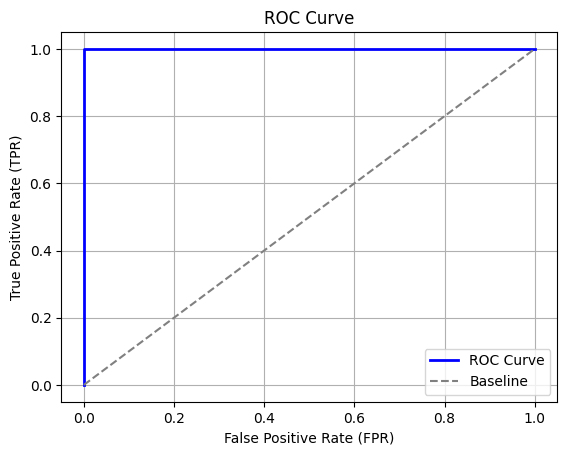

In [17]:
# Predict the probabilities of the air system having or not having a defect
scores = rf.predict_proba(X_selected)[:, 1]

# Generate the ROC curve
fpr, tpr, thresholds = roc_curve(y, scores)

# Calculate the threshold that minimizes the cost
min_cost = np.inf
best_threshold = 0.5
costs = []
for threshold in thresholds:
    y_pred_threshold = scores > threshold
    tn, fp, fn, tp = confusion_matrix(y, y_pred_threshold).ravel()
    cost = 10 * fp + 500 * fn
    costs.append(cost)
    if cost < min_cost:
        min_cost = cost
        best_threshold = threshold
print("Best threshold: {:.4f}".format(best_threshold))

# Plot the ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Baseline')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


# Model Validation


In [18]:
# Opening the test set
cols_to_convert = df_test.columns[1:]
df_test[cols_to_convert] = df_test[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Preprocessing
df_test = preprocess(df_test)

# Select input and output
X_test = df_test.drop('class', axis=1)
y_test = df_test['class'].astype(int)

# Normalize
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)

# SelectKBest
X_test_selected = selector.transform(X_test)

# Predict probabilities
probabilities_test = rf.predict_proba(X_test_selected)[:, 1]

# Apply the best_threshold calculated during model training
y_pred_test = probabilities_test > best_threshold

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:", accuracy)

# Convert accuracy to percentage and round to the nearest integer
accuracy_percentage = round(accuracy * 100)

print("Accuracy: {}%".format(accuracy_percentage))


/tmp/ipykernel_18/1073350842.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.39698389e-06 1.90921132e-06 1.53672885e-03 ... 1.85417016e-03
 2.56113714e-06 1.86264519e-07]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


Accuracy: 0.972
Accuracy: 97%


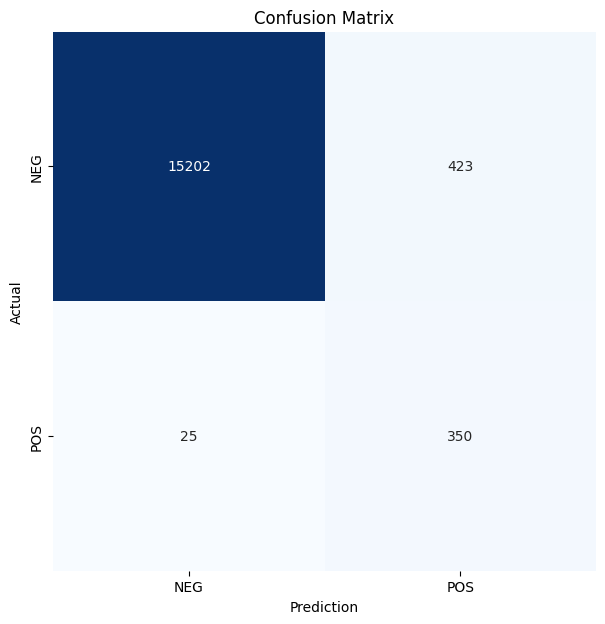

In [19]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Define the labels for the confusion matrix with the desired scales
class_names = ['NEG', 'POS']

# Plot the confusion matrix with the desired scales
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()


In [20]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     15625
           1       0.45      0.93      0.61       375

    accuracy                           0.97     16000
   macro avg       0.73      0.95      0.80     16000
weighted avg       0.99      0.97      0.98     16000



In [21]:
# Define the weights for false positives and false negatives
fp_weight = 10  # Weight for false positive
fn_weight = 500  # Weight for false negative

# Extract values from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate costs based on the defined weights
total_cost = fp * fp_weight + fn * fn_weight

print("Total Cost: {:.2f}".format(total_cost))


Total Cost: 16730.00
